# Energy Market Forecasting Framework

## Interpretable Elastic Net Models for Gas, Power, and Carbon Markets

**Framework Overview:**
1. Define 3 targets (Natural Gas, Electricity, Carbon) with log-return transformation
2. Build shared feature engine with supply/demand blocks
3. Add target-specific features
4. Train interpretable Elastic Net models with lags
5. Walk-forward validation for robust performance assessment
6. Regime-ready structure for future enhancements

**Target Transformation:**
$$y_t = \Delta \log(P_t) = \log(P_t) - \log(P_{t-1})$$

This reduces shared trend problems and makes coefficients interpretable as "impact on percent change".

## Step 1: Import Libraries and Load Data

Import required modules and load raw energy market data.

In [9]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime

# Import custom modules
from data_extractor import DataExtractor
from feature_engineering import FeatureEngineer
from target_transforms import TargetTransformer, prepare_all_targets
from model_framework import EnergyMarketModel, WalkForwardValidator
import config

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

print("Libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")

Libraries imported successfully!
Working directory: c:\Users\jeffh\OneDrive\Documents\MSQF Fordham\ML Internship\Workspace\KtE_Project


In [10]:
# Load and process raw data
extractor = DataExtractor("raw_data_2021_2024.csv")
df_raw = extractor.load_data()

# Handle missing data with interpolation
df = extractor.handle_missing_data(method='interpolate')
df.index = pd.to_datetime(df.index, errors='coerce')
# Display data summary
print(f"\nData shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

Data loaded successfully from raw_data_2021_2024.csv
Shape: (1020, 100)
Date range: 44201 to 45656
Missing values: 32646

Handling missing data using method: interpolate
Missing values before: 32646
Missing values after: 39

Data shape: (1020, 100)

First few rows:
                               BM_TTF_M1_OPEN_EUR_MWH  BM_TTF_M1_HIGH_EUR_MWH  \
Date                                                                            
1970-01-01 00:00:00.000044201                   18.75                   17.93   
1970-01-01 00:00:00.000044202                   18.23                   17.58   
1970-01-01 00:00:00.000044203                   18.38                   19.40   
1970-01-01 00:00:00.000044204                   20.45                   20.38   
1970-01-01 00:00:00.000044207                   21.50                   22.55   

                               BM_TTF_M1_LOW_EUR_MWH  BM_TTF_M1_CLOSE_EUR_MWH  \
Date                                                                            
1970

c:\Users\jeffh\OneDrive\Documents\MSQF Fordham\ML Internship\Workspace\KtE_Project\data_extractor.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df = pd.read_csv(self.data_path, index_col=0, parse_dates=True)


## Step 2: Define and Transform Targets

**Target Definitions:**
- **Natural Gas (TTF):** `BM_TTF_M1_CLOSE_EUR_MWH`
- **Electricity (Germany Power):** `BM_GERMANY_POWER_M1_CLOSE_EUR_MWH`  
- **Carbon (EUA):** `BM_EUA_CO2_CAL1_PRICE_EUR_TON`

**Transformation:** Convert prices to log-returns for:
- Removing shared trends
- Making coefficients interpretable (% change impact)
- Improving model robustness

In [11]:
# Prepare all three targets with transformations
targets_data = prepare_all_targets(df)

# Extract individual components for each target
gas_data = targets_data['gas']
power_data = targets_data['power']
carbon_data = targets_data['carbon']

print("\n" + "="*70)
print("TARGETS PREPARED")
print("="*70)
for target_name, target_info in targets_data.items():
    print(f"\n{target_name.upper()}:")
    print(f"  Return column: {target_info['return_column']}")
    print(f"  Non-null returns: {target_info['data'][target_info['return_column']].notna().sum()}")


Preparing target: GAS

Target Transformation: Natural Gas (TTF)
Original price column: BM_TTF_M1_CLOSE_EUR_MWH
Price range: 15.48 - 297.00 EUR/MWh
Return column: gas_return
Return mean: 0.000951
Return std: 0.053967
Non-null observations: 1019

Preparing target: POWER

Target Transformation: Electricity (Germany)
Original price column: BM_GERMANY_POWER_M1_CLOSE_EUR_MWH
Price range: 41.50 - 604.00 EUR/MWh
Return column: power_return
Return mean: 0.000846
Return std: 0.053668
Non-null observations: 1019

Preparing target: CARBON

Target Transformation: Carbon (EUA)
Original price column: BM_EUA_CO2_CAL1_PRICE_EUR_TON
Price range: 31.62 - 100.34 EUR/ton
Return column: carbon_return
Return mean: 0.000767
Return std: 0.026412
Non-null observations: 1019

TARGETS PREPARED

GAS:
  Return column: gas_return
  Non-null returns: 1019

POWER:
  Return column: power_return
  Non-null returns: 1019

CARBON:
  Return column: carbon_return
  Non-null returns: 1019


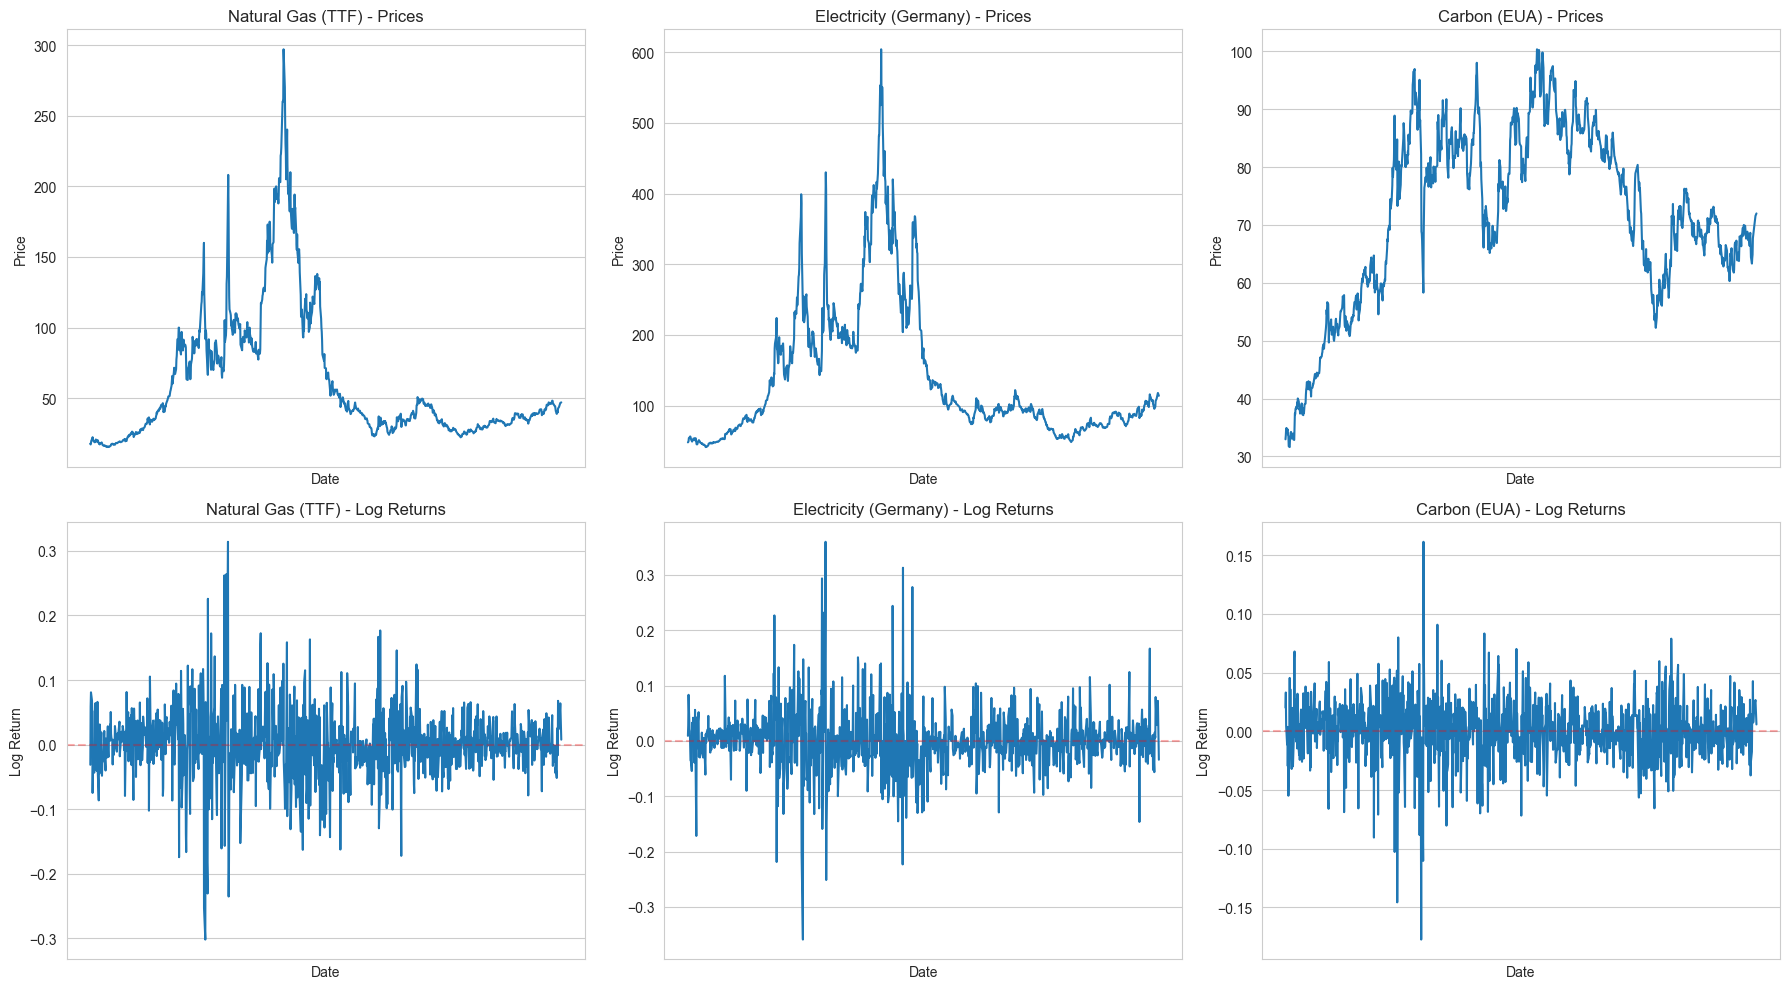

In [ ]:
# Visualize targets (prices and returns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

targets = ['gas', 'power', 'carbon']
titles = ['Natural Gas (TTF)', 'Electricity (Germany)', 'Carbon (EUA)']

for idx, (target, title) in enumerate(zip(targets, titles)):
    # Plot prices
    targets_data[target]['prices'].plot(ax=axes[0, idx], title=f"{title} - Prices")
    axes[0, idx].set_ylabel('Price')
    axes[0, idx].grid(True)
    
    # Plot returns
    targets_data[target]['data'][targets_data[target]['return_column']].plot(
        ax=axes[1, idx], title=f"{title} - Log Returns"
    )
    axes[1, idx].set_ylabel('Log Return')
    axes[1, idx].axhline(y=0, color='r', linestyle='--', alpha=0.3)
    axes[1, idx].grid(True)
    

plt.tight_layout()
plt.show()

## Step 3: Feature Engineering

Build features in **4 blocks** + target-specific additions:

**1. Demand Block** (seasonal)
- Temperature anomalies (actual - normal)
- Load (Germany, France)
- Gas consumption anomalies

**2. Supply Block**
- Norway outages, Russian flows, LNG imports
- EU storage levels
- Renewables and nuclear generation

**3. Market Positioning Block**
- COT net positions (TTF, EUA)
- Options implied volatility
- Fuel switch indicators

**4. Cross-Commodity Block**
- Coal, Brent, JKM, Henry Hub
- Price returns for cross-market dynamics

In [5]:
# Build features for Natural Gas (TTF)
print("="*70)
print("BUILDING FEATURES FOR NATURAL GAS")
print("="*70)

fe_gas = FeatureEngineer(df)
X_gas = fe_gas.build_all_features(target='gas', add_lags_to_features=True)

print(f"\n Gas features shape: {X_gas.shape}")
print(f"Feature names (first 20): {X_gas.columns[:20].tolist()}")

BUILDING FEATURES FOR NATURAL GAS

BUILDING COMPLETE FEATURE SET FOR GAS

Building DEMAND block
Created anomaly: MF_TEMPERATURE_GERMANY_ACTUAL_C_ANOMALY
Created anomaly: MF_TEMPERATURE_FRANCE_ACTUAL_C_ANOMALY
Created anomaly: MF_GAS_CONSUMPTION_GERMANY_ACTUAL_GWH_D_ANOMALY
Created anomaly: MF_GAS_CONSUMPTION_FRANCE_ACTUAL_GWH_D_ANOMALY

Building SUPPLY block

Building MARKET POSITIONING block

Building CROSS-COMMODITY block

Adding TARGET-SPECIFIC features for GAS

Adding lags [1, 2, 5] for 5 features...

Feature engineering complete!
Total features: 59
Date range: 44201 to 45656

 Gas features shape: (1020, 59)
Feature names (first 20): ['MF_TEMPERATURE_GERMANY_ACTUAL_C', 'MF_TEMPERATURE_FRANCE_ACTUAL_C', 'MF_TEMPERATURE_NORMAL_GERMANY_NORMAL_C', 'MF_TEMPERATURE_NORMAL_FRANCE_NORMAL_C', 'MF_POWER_LOAD_GERMANY_ACTUAL_LOAD_GW', 'MF_POWER_LOAD_FRANCE_ACTUAL_LOAD_GW', 'MF_GAS_CONSUMPTION_GERMANY_ACTUAL_GWH_D', 'MF_GAS_CONSUMPTION_FRANCE_ACTUAL_GWH_D', 'MF_GAS_CONSUMPTION_GERMANY_AVG_2Y_GW

In [6]:
# Build features for Electricity (Power)
print("\n" + "="*70)
print("BUILDING FEATURES FOR ELECTRICITY")
print("="*70)

fe_power = FeatureEngineer(df)
X_power = fe_power.build_all_features(target='power', add_lags_to_features=True)

print(f"\nPower features shape: {X_power.shape}")


BUILDING FEATURES FOR ELECTRICITY

BUILDING COMPLETE FEATURE SET FOR POWER

Building DEMAND block
Created anomaly: MF_TEMPERATURE_GERMANY_ACTUAL_C_ANOMALY
Created anomaly: MF_TEMPERATURE_FRANCE_ACTUAL_C_ANOMALY
Created anomaly: MF_GAS_CONSUMPTION_GERMANY_ACTUAL_GWH_D_ANOMALY
Created anomaly: MF_GAS_CONSUMPTION_FRANCE_ACTUAL_GWH_D_ANOMALY

Building SUPPLY block

Building MARKET POSITIONING block

Building CROSS-COMMODITY block

Adding TARGET-SPECIFIC features for POWER
Added: BM_TTF_M1_CLOSE_EUR_MWH
Added: IM_SPOT_GAS_TTF_DA_PRICE_EUR_MWH
Added: BM_EUA_CO2_CAL1_PRICE_EUR_TON
Added: MF_TRANSFER_CAPACITY_IMPORT_FRANCE_CAPACITY_GW
Added: MF_TRANSFER_CAPACITY_IMPORT_SCANDINAVIA_CAPACITY_GW

Adding lags [1, 2, 5] for 5 features...

Feature engineering complete!
Total features: 64
Date range: 44201 to 45656

Power features shape: (1020, 64)


In [7]:
# Build features for Carbon (EUA)
print("\n" + "="*70)
print("BUILDING FEATURES FOR CARBON")
print("="*70)

fe_carbon = FeatureEngineer(df)
X_carbon = fe_carbon.build_all_features(target='carbon', add_lags_to_features=True)

print(f"\nCarbon features shape: {X_carbon.shape}")


BUILDING FEATURES FOR CARBON

BUILDING COMPLETE FEATURE SET FOR CARBON

Building DEMAND block
Created anomaly: MF_TEMPERATURE_GERMANY_ACTUAL_C_ANOMALY
Created anomaly: MF_TEMPERATURE_FRANCE_ACTUAL_C_ANOMALY
Created anomaly: MF_GAS_CONSUMPTION_GERMANY_ACTUAL_GWH_D_ANOMALY
Created anomaly: MF_GAS_CONSUMPTION_FRANCE_ACTUAL_GWH_D_ANOMALY

Building SUPPLY block

Building MARKET POSITIONING block

Building CROSS-COMMODITY block

Adding TARGET-SPECIFIC features for CARBON
Added: BM_GERMANY_POWER_M1_CLOSE_EUR_MWH
Added: BM_TTF_M1_CLOSE_EUR_MWH

Adding lags [1, 2, 5] for 5 features...

Feature engineering complete!
Total features: 61
Date range: 44201 to 45656

Carbon features shape: (1020, 61)


## Step 4: Train Elastic Net Models with Lags

**Model specification:**
$$y_t = \alpha + \sum_{i=1}^{p} \phi_i y_{t-i} + X_t^T \beta + \varepsilon_t$$

**Elastic Net regularization:**
- Balances L1 (Lasso) and L2 (Ridge) penalties
- Produces sparse, interpretable coefficients
- Handles correlated features well
- Uses cross-validation to select optimal alpha

**Lags included:**
- Target lags: [1, 2, 3, 5, 10] days
- Feature lags: [1, 2, 5] days for key drivers

In [8]:
# Initialize models for each target
model_gas = EnergyMarketModel(target_name='gas', use_cv=True)
model_power = EnergyMarketModel(target_name='power', use_cv=True)
model_carbon = EnergyMarketModel(target_name='carbon', use_cv=True)

print("Models initialized!")
print(f"\nModel parameters:")
print(f"  L1 ratio: {config.MODEL_PARAMS['elastic_net']['l1_ratio']}")
print(f"  CV folds: {config.MODEL_PARAMS['elastic_net']['cv_folds']}")
print(f"  Target lags: {config.MODEL_PARAMS['lags']['target_lags']}")
print(f"  Feature lags: {config.MODEL_PARAMS['lags']['feature_lags']}")

Models initialized!

Model parameters:
  L1 ratio: 0.5
  CV folds: 5
  Target lags: [1, 2, 3, 5, 10]
  Feature lags: [1, 2, 5]


## Step 5: Walk-Forward Validation

**Time series validation approach:**
- **Initial train size:** 252 days (~1 year)
- **Step size:** 21 days (~1 month)
- **Method:** Rolling or expanding window
- **Horizon:** 1-step ahead forecast

This ensures models are tested on truly out-of-sample data and prevents look-ahead bias.

In [9]:
# Validate Natural Gas model
print("="*70)
print("VALIDATING NATURAL GAS MODEL")
print("="*70)

validator_gas = WalkForwardValidator(
    initial_train_size=252,
    step_size=21,
    horizon=1
)

y_gas = gas_data['data'][gas_data['return_column']]
results_gas = validator_gas.validate(model_gas, X_gas, y_gas, expanding=False)

# Display results
print("\nValidation Results Summary:")
print(results_gas[['fold', 'train_size', 'test_size', 'rmse', 'mae', 'r2']].head(10))

VALIDATING NATURAL GAS MODEL

Walk-Forward Validation: GAS
Initial train size: 252 days
Step size: 21 days
Window type: Rolling


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.291e-04, tolerance: 5.196e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.366e-04, tolerance: 5.196e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 1: RMSE=0.091359, MAE=0.069860, R²=0.2076


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.197e-04, tolerance: 7.313e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.072e-05, tolerance: 7.456e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 2: RMSE=0.076718, MAE=0.053258, R²=0.1835


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.034e-04, tolerance: 8.806e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.230e-04, tolerance: 8.806e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 3: RMSE=0.106556, MAE=0.081068, R²=0.3078


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-04, tolerance: 1.218e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e-04, tolerance: 1.218e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 4: RMSE=0.052590, MAE=0.037210, R²=0.0005


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.485e-04, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.979e-04, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 5: RMSE=0.038594, MAE=0.031192, R²=0.0489


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-04, tolerance: 1.293e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.629e-04, tolerance: 1.293e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 6: RMSE=0.050809, MAE=0.032787, R²=0.2494


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.488e-04, tolerance: 1.336e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.529e-04, tolerance: 1.336e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 7: RMSE=0.057530, MAE=0.046319, R²=0.0005


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.898e-04, tolerance: 1.306e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.879e-04, tolerance: 1.306e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 8: RMSE=0.044880, MAE=0.037444, R²=-0.0956


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.754e-04, tolerance: 1.233e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.936e-04, tolerance: 1.233e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 9: RMSE=0.067308, MAE=0.059177, R²=0.2075


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.839e-04, tolerance: 1.306e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.541e-04, tolerance: 1.306e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 10: RMSE=0.061333, MAE=0.047892, R²=0.0344


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.570e-04, tolerance: 1.034e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.007e-03, tolerance: 1.034e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 11: RMSE=0.076016, MAE=0.058393, R²=0.0255


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.249e-04, tolerance: 1.064e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.696e-03, tolerance: 1.064e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 12: RMSE=0.051124, MAE=0.039026, R²=0.1305


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.088e-04, tolerance: 1.163e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.146e-04, tolerance: 1.163e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 13: RMSE=0.054254, MAE=0.043007, R²=0.2129


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.205e-03, tolerance: 7.463e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.341e-03, tolerance: 7.463e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 14: RMSE=0.043620, MAE=0.032436, R²=0.0997


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.444e-04, tolerance: 7.522e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.596e-04, tolerance: 7.522e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 15: RMSE=0.050698, MAE=0.035592, R²=0.0999


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.354e-05, tolerance: 7.278e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.333e-05, tolerance: 7.278e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 16: RMSE=0.027566, MAE=0.019485, R²=0.1146


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.182e-05, tolerance: 6.781e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.337e-05, tolerance: 6.781e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 17: RMSE=0.021893, MAE=0.015448, R²=-0.1945


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.403e-04, tolerance: 6.321e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.978e-04, tolerance: 6.321e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 18: RMSE=0.078501, MAE=0.060457, R²=0.0102


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.740e-04, tolerance: 6.586e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.893e-04, tolerance: 6.586e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 19: RMSE=0.039347, MAE=0.031006, R²=0.1782


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.540e-05, tolerance: 6.219e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.580e-05, tolerance: 6.219e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 20: RMSE=0.052557, MAE=0.039804, R²=0.0347


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.416e-04, tolerance: 5.764e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.411e-03, tolerance: 5.764e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 21: RMSE=0.051057, MAE=0.037860, R²=0.2822


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.180e-04, tolerance: 5.780e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.673e-04, tolerance: 5.780e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 22: RMSE=0.046988, MAE=0.037623, R²=0.2088


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.279e-04, tolerance: 6.071e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.355e-04, tolerance: 6.071e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 23: RMSE=0.023904, MAE=0.020474, R²=0.1137


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.237e-04, tolerance: 5.154e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.676e-04, tolerance: 5.154e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 24: RMSE=0.027368, MAE=0.022068, R²=0.2414


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.475e-05, tolerance: 4.615e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.525e-04, tolerance: 5.526e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 25: RMSE=0.027725, MAE=0.023523, R²=0.3312


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.753e-04, tolerance: 4.622e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.837e-05, tolerance: 4.622e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 26: RMSE=0.028533, MAE=0.022412, R²=0.0758


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.702e-05, tolerance: 4.723e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.095e-04, tolerance: 4.723e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 27: RMSE=0.018478, MAE=0.012845, R²=0.4831


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.023e-04, tolerance: 3.176e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e-04, tolerance: 3.176e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 28: RMSE=0.036164, MAE=0.028892, R²=-0.1333


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.781e-05, tolerance: 3.697e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.201e-05, tolerance: 3.697e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 29: RMSE=0.022752, MAE=0.016522, R²=0.0588


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.209e-04, tolerance: 3.479e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.385e-04, tolerance: 3.479e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 30: RMSE=0.021434, MAE=0.017716, R²=0.2837


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.190e-05, tolerance: 2.176e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.240e-05, tolerance: 2.176e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 31: RMSE=0.019697, MAE=0.015931, R²=-1.0262
Fold 32: RMSE=0.019406, MAE=0.012761, R²=0.2127


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.096e-05, tolerance: 1.563e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.747e-05, tolerance: 1.563e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 33: RMSE=0.017877, MAE=0.015074, R²=0.3154


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e-05, tolerance: 1.789e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.887e-05, tolerance: 1.789e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 34: RMSE=0.024807, MAE=0.018963, R²=0.2561


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.978e-05, tolerance: 1.454e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.503e-05, tolerance: 1.454e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 35: RMSE=0.023481, MAE=0.018383, R²=0.1548


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.249e-05, tolerance: 1.623e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.026e-04, tolerance: 1.623e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 36: RMSE=0.021274, MAE=0.016463, R²=0.1394

Validation Summary:
Total folds: 36
Average RMSE: 0.043728
Average MAE: 0.033566
Average R²: 0.1070

Validation Results Summary:
   fold  train_size  test_size      rmse       mae        r2
0     1         252         21  0.091359  0.069860  0.207638
1     2         252         21  0.076718  0.053258  0.183467
2     3         252         21  0.106556  0.081068  0.307843
3     4         252         21  0.052590  0.037210  0.000490
4     5         252         21  0.038594  0.031192  0.048874
5     6         252         21  0.050809  0.032787  0.249441
6     7         252         21  0.057530  0.046319  0.000490
7     8         252         21  0.044880  0.037444 -0.095635
8     9         252         21  0.067308  0.059177  0.207456
9    10         252         21  0.061333  0.047892  0.034449


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.502e-04, tolerance: 1.532e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.174e-04, tolerance: 1.532e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

In [10]:
# Validate Electricity model
print("\n" + "="*70)
print("VALIDATING ELECTRICITY MODEL")
print("="*70)

validator_power = WalkForwardValidator(
    initial_train_size=252,
    step_size=21,
    horizon=1
)

y_power = power_data['data'][power_data['return_column']]
results_power = validator_power.validate(model_power, X_power, y_power, expanding=False)

print("\nValidation Results Summary:")
print(results_power[['fold', 'train_size', 'test_size', 'rmse', 'mae', 'r2']].head(10))


VALIDATING ELECTRICITY MODEL

Walk-Forward Validation: POWER
Initial train size: 252 days
Step size: 21 days
Window type: Rolling


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.159e-04, tolerance: 5.071e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.216e-04, tolerance: 5.071e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 1: RMSE=0.077472, MAE=0.051542, R²=-0.1050


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.451e-04, tolerance: 6.873e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.528e-04, tolerance: 6.873e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 2: RMSE=0.056198, MAE=0.041036, R²=0.5589


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.095e-04, tolerance: 8.370e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.094e-04, tolerance: 8.417e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 3: RMSE=0.052757, MAE=0.042983, R²=0.8343


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e-04, tolerance: 1.178e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.959e-04, tolerance: 1.178e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 4: RMSE=0.042240, MAE=0.037649, R²=0.2904


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.562e-04, tolerance: 1.156e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.268e-04, tolerance: 1.156e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 5: RMSE=0.023680, MAE=0.018830, R²=0.5816


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.442e-04, tolerance: 1.259e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.485e-04, tolerance: 1.259e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 6: RMSE=0.028570, MAE=0.019336, R²=0.7229


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.164e-04, tolerance: 1.297e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.097e-04, tolerance: 1.297e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 7: RMSE=0.032937, MAE=0.024727, R²=0.6874


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.036e-04, tolerance: 1.197e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.899e-04, tolerance: 1.197e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 8: RMSE=0.031154, MAE=0.022467, R²=0.5971


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.268e-04, tolerance: 1.181e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.355e-04, tolerance: 1.181e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 9: RMSE=0.058371, MAE=0.046244, R²=0.3263


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.477e-04, tolerance: 9.229e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.668e-04, tolerance: 9.229e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 10: RMSE=0.075410, MAE=0.050050, R²=0.0612


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e-04, tolerance: 1.050e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.076e-04, tolerance: 9.292e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 11: RMSE=0.088136, MAE=0.047845, R²=0.2441


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.083e-04, tolerance: 1.075e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.130e-04, tolerance: 1.075e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 12: RMSE=0.064280, MAE=0.042365, R²=0.4018
Fold 13: RMSE=0.038390, MAE=0.030498, R²=0.4255


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.091e-04, tolerance: 9.327e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.660e-04, tolerance: 1.330e-04
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 14: RMSE=0.027750, MAE=0.018068, R²=-0.0114


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.397e-04, tolerance: 9.048e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.068e-04, tolerance: 9.048e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 15: RMSE=0.032683, MAE=0.025042, R²=0.3939


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.657e-05, tolerance: 8.766e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.813e-04, tolerance: 8.766e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 16: RMSE=0.025132, MAE=0.019588, R²=-0.4248


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.173e-05, tolerance: 8.117e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.415e-04, tolerance: 8.117e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 17: RMSE=0.023364, MAE=0.019788, R²=-2.1775


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.742e-05, tolerance: 7.597e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.380e-04, tolerance: 7.597e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 18: RMSE=0.045478, MAE=0.034215, R²=0.2144


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.330e-04, tolerance: 7.166e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.904e-05, tolerance: 7.166e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 19: RMSE=0.029625, MAE=0.023159, R²=0.1410


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.618e-04, tolerance: 6.093e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.665e-04, tolerance: 6.093e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 20: RMSE=0.031825, MAE=0.022202, R²=-0.0912


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.276e-05, tolerance: 4.078e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.164e-05, tolerance: 4.078e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 21: RMSE=0.037503, MAE=0.029805, R²=0.1429


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.577e-05, tolerance: 2.950e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.016e-05, tolerance: 2.950e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 22: RMSE=0.042360, MAE=0.034044, R²=0.0677


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.510e-05, tolerance: 4.493e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.166e-05, tolerance: 4.493e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 23: RMSE=0.024148, MAE=0.020603, R²=0.1780


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.020e-05, tolerance: 3.224e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.143e-04, tolerance: 3.224e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 24: RMSE=0.033229, MAE=0.025433, R²=0.2205


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.643e-05, tolerance: 2.210e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.618e-05, tolerance: 2.210e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 25: RMSE=0.030090, MAE=0.020537, R²=0.4636


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.149e-05, tolerance: 2.693e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.278e-05, tolerance: 2.693e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 26: RMSE=0.025134, MAE=0.018641, R²=0.0478


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.671e-04, tolerance: 2.394e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.952e-05, tolerance: 2.596e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 27: RMSE=0.025182, MAE=0.019310, R²=0.3674


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.719e-05, tolerance: 2.667e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.567e-04, tolerance: 2.667e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 28: RMSE=0.037113, MAE=0.028011, R²=0.2535


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.360e-04, tolerance: 2.626e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.547e-04, tolerance: 2.626e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 29: RMSE=0.028832, MAE=0.018671, R²=0.2700


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.394e-04, tolerance: 2.664e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.579e-04, tolerance: 2.664e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 30: RMSE=0.031835, MAE=0.023575, R²=0.3905


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.784e-04, tolerance: 2.685e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.149e-04, tolerance: 2.685e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 31: RMSE=0.013966, MAE=0.010197, R²=0.2750


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.604e-05, tolerance: 2.556e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.770e-04, tolerance: 2.556e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 32: RMSE=0.026229, MAE=0.017130, R²=-0.0286


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.881e-05, tolerance: 2.319e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.603e-05, tolerance: 2.319e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 33: RMSE=0.014496, MAE=0.012322, R²=0.4674


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.467e-05, tolerance: 2.184e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.059e-05, tolerance: 2.184e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 34: RMSE=0.026784, MAE=0.015749, R²=0.4132


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.584e-05, tolerance: 2.031e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.479e-04, tolerance: 2.031e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 35: RMSE=0.032506, MAE=0.024444, R²=0.3694


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.936e-05, tolerance: 2.340e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.507e-04, tolerance: 2.340e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 36: RMSE=0.038492, MAE=0.023903, R²=0.2410

Validation Summary:
Total folds: 36
Average RMSE: 0.037593
Average MAE: 0.027222
Average R²: 0.2169

Validation Results Summary:
   fold  train_size  test_size      rmse       mae        r2
0     1         252         21  0.077472  0.051542 -0.104954
1     2         252         21  0.056198  0.041036  0.558851
2     3         252         21  0.052757  0.042983  0.834276
3     4         252         21  0.042240  0.037649  0.290361
4     5         252         21  0.023680  0.018830  0.581586
5     6         252         21  0.028570  0.019336  0.722900
6     7         252         21  0.032937  0.024727  0.687421
7     8         252         21  0.031154  0.022467  0.597118
8     9         252         21  0.058371  0.046244  0.326324
9    10         252         21  0.075410  0.050050  0.061157


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.886e-05, tolerance: 2.286e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.605e-05, tolerance: 2.286e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

In [11]:
# Validate Carbon model
print("\n" + "="*70)
print("VALIDATING CARBON MODEL")
print("="*70)

validator_carbon = WalkForwardValidator(
    initial_train_size=252,
    step_size=21,
    horizon=1
)

y_carbon = carbon_data['data'][carbon_data['return_column']]
results_carbon = validator_carbon.validate(model_carbon, X_carbon, y_carbon, expanding=False)

print("\nValidation Results Summary:")
print(results_carbon[['fold', 'train_size', 'test_size', 'rmse', 'mae', 'r2']].head(10))


VALIDATING CARBON MODEL

Walk-Forward Validation: CARBON
Initial train size: 252 days
Step size: 21 days
Window type: Rolling


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.353e-05, tolerance: 1.163e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.337e-05, tolerance: 1.163e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 1: RMSE=0.027052, MAE=0.022075, R²=-0.1337


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.322e-04, tolerance: 1.300e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.975e-04, tolerance: 1.300e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 2: RMSE=0.033668, MAE=0.022571, R²=-0.0759


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.249e-04, tolerance: 1.522e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.244e-04, tolerance: 1.522e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 3: RMSE=0.088250, MAE=0.067290, R²=-0.8772


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.371e-05, tolerance: 2.370e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.452e-05, tolerance: 2.370e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 4: RMSE=0.032069, MAE=0.024362, R²=-0.0001


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.106e-05, tolerance: 2.581e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.234e-05, tolerance: 2.581e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 5: RMSE=0.031725, MAE=0.023967, R²=-0.0002


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.062e-05, tolerance: 2.689e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.065e-05, tolerance: 2.689e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 6: RMSE=0.023108, MAE=0.017009, R²=-0.0152


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.872e-05, tolerance: 2.751e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.927e-05, tolerance: 2.751e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 7: RMSE=0.023847, MAE=0.018792, R²=-0.0697


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.912e-04, tolerance: 2.605e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.025e-04, tolerance: 2.605e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 8: RMSE=0.023280, MAE=0.018001, R²=-0.0741


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-04, tolerance: 2.629e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.503e-04, tolerance: 2.629e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 9: RMSE=0.036076, MAE=0.028048, R²=-0.1574


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.327e-04, tolerance: 2.330e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.279e-04, tolerance: 2.330e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 10: RMSE=0.028719, MAE=0.020927, R²=-0.0091


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.267e-04, tolerance: 2.324e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.573e-04, tolerance: 2.324e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 11: RMSE=0.030477, MAE=0.023628, R²=-0.0141


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.319e-04, tolerance: 2.390e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.322e-04, tolerance: 2.390e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 12: RMSE=0.020193, MAE=0.016419, R²=-0.1606


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.307e-04, tolerance: 1.529e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.347e-04, tolerance: 1.529e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 13: RMSE=0.030659, MAE=0.023498, R²=-0.0001


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.130e-04, tolerance: 1.525e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.838e-04, tolerance: 1.525e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 14: RMSE=0.024410, MAE=0.018630, R²=-0.0859


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.253e-04, tolerance: 1.421e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.168e-04, tolerance: 1.421e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 15: RMSE=0.024092, MAE=0.020154, R²=-0.0363


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.728e-04, tolerance: 1.414e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.645e-04, tolerance: 1.414e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 16: RMSE=0.020244, MAE=0.015774, R²=0.0649


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.228e-04, tolerance: 1.412e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.656e-04, tolerance: 1.412e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 17: RMSE=0.017697, MAE=0.014885, R²=-0.0648


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e-05, tolerance: 1.368e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e-05, tolerance: 1.368e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 18: RMSE=0.021519, MAE=0.017414, R²=-0.0251


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.239e-05, tolerance: 1.162e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.218e-05, tolerance: 1.162e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 19: RMSE=0.017385, MAE=0.012682, R²=-0.1310


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.127e-05, tolerance: 1.032e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.168e-05, tolerance: 1.032e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 20: RMSE=0.012704, MAE=0.011394, R²=0.2453


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.313e-05, tolerance: 9.066e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.510e-05, tolerance: 9.066e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 21: RMSE=0.012910, MAE=0.011046, R²=-0.0993


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.578e-05, tolerance: 8.450e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.623e-05, tolerance: 8.450e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 22: RMSE=0.017380, MAE=0.013805, R²=-0.0124


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.033e-05, tolerance: 7.356e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.641e-05, tolerance: 7.356e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 23: RMSE=0.010352, MAE=0.008508, R²=0.0608


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.922e-05, tolerance: 6.186e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.538e-05, tolerance: 6.186e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 24: RMSE=0.023095, MAE=0.019560, R²=-0.6685


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.605e-05, tolerance: 5.712e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.020e-05, tolerance: 5.712e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 25: RMSE=0.029598, MAE=0.025002, R²=0.0031


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.483e-05, tolerance: 6.553e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.580e-05, tolerance: 6.553e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 26: RMSE=0.022564, MAE=0.019772, R²=0.0816


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.017e-05, tolerance: 7.106e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.916e-06, tolerance: 7.514e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 27: RMSE=0.026991, MAE=0.021462, R²=0.1775


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.202e-05, tolerance: 7.981e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.909e-05, tolerance: 7.981e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 28: RMSE=0.034187, MAE=0.028366, R²=-0.0059


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.508e-04, tolerance: 1.016e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e-04, tolerance: 1.016e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 29: RMSE=0.024648, MAE=0.020339, R²=0.2186


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e-05, tolerance: 1.133e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.330e-05, tolerance: 1.133e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 30: RMSE=0.015489, MAE=0.011656, R²=0.2880


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.295e-04, tolerance: 1.173e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.039e-03, tolerance: 1.173e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 31: RMSE=0.015407, MAE=0.011741, R²=-0.0706


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.288e-05, tolerance: 1.129e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.069e-04, tolerance: 1.129e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 32: RMSE=0.016003, MAE=0.013190, R²=0.2920


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.122e-05, tolerance: 1.215e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.533e-05, tolerance: 1.215e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 33: RMSE=0.010797, MAE=0.009217, R²=0.2712


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e-05, tolerance: 1.172e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.338e-05, tolerance: 1.172e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 34: RMSE=0.016154, MAE=0.012065, R²=0.2902


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.871e-05, tolerance: 1.085e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.426e-05, tolerance: 1.085e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 35: RMSE=0.017439, MAE=0.013223, R²=0.2402


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.172e-04, tolerance: 1.036e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.051e-04, tolerance: 1.036e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

Fold 36: RMSE=0.012620, MAE=0.010485, R²=0.2650

Validation Summary:
Total folds: 36
Average RMSE: 0.024245
Average MAE: 0.019082
Average R²: -0.0080

Validation Results Summary:
   fold  train_size  test_size      rmse       mae        r2
0     1         252         21  0.027052  0.022075 -0.133745
1     2         252         21  0.033668  0.022571 -0.075933
2     3         252         21  0.088250  0.067290 -0.877196
3     4         252         21  0.032069  0.024362 -0.000125
4     5         252         21  0.031725  0.023967 -0.000151
5     6         252         21  0.023108  0.017009 -0.015170
6     7         252         21  0.023847  0.018792 -0.069710
7     8         252         21  0.023280  0.018001 -0.074109
8     9         252         21  0.036076  0.028048 -0.157378
9    10         252         21  0.028719  0.020927 -0.009147


c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.035e-05, tolerance: 1.186e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.996e-05, tolerance: 1.186e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jeffh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, che

## Step 6: Model Interpretation - Top Features

Analyze which features have the strongest impact on each target market.

In [12]:
# Get top features for each model
print("="*70)
print("TOP 15 FEATURES BY ABSOLUTE COEFFICIENT")
print("="*70)

print("\n--- NATURAL GAS (TTF) ---")
print(model_gas.get_top_features(15))

print("\n--- ELECTRICITY (GERMANY POWER) ---")
print(model_power.get_top_features(15))

print("\n--- CARBON (EUA) ---")
print(model_carbon.get_top_features(15))

TOP 15 FEATURES BY ABSOLUTE COEFFICIENT

--- NATURAL GAS (TTF) ---
                                         feature  coefficient  abs_coefficient
0                                      intercept    -0.000003         0.000003
1              IM_COAL_CAL1_PRICE_USD_TON_RETURN     0.011885         0.011885
2           IM_JKM_LNG_M1_PRICE_USD_MMBTU_RETURN     0.002916         0.002916
3   MF_TEMPERATURE_GERMANY_ACTUAL_C_ANOMALY_LAG1     0.001480         0.001480
4     IM_COAL_GAS_SWITCH_CAL1_RESISTANCE_EUR_MWH     0.001346         0.001346
5                       MF_COT_TTF_TOTAL_NET_MWH     0.001044         0.001044
6                     IM_COAL_CAL1_PRICE_USD_TON     0.000963         0.000963
7        IM_TTF_OPTIONS_TTF_IMPLIED_VOL_PCT_LAG2    -0.000223         0.000223
8      MF_POWER_LOAD_GERMANY_ACTUAL_LOAD_GW_LAG2    -0.000117         0.000117
9                                   target_lag_3    -0.000096         0.000096
10               MF_TEMPERATURE_GERMANY_ACTUAL_C    -0.000000   

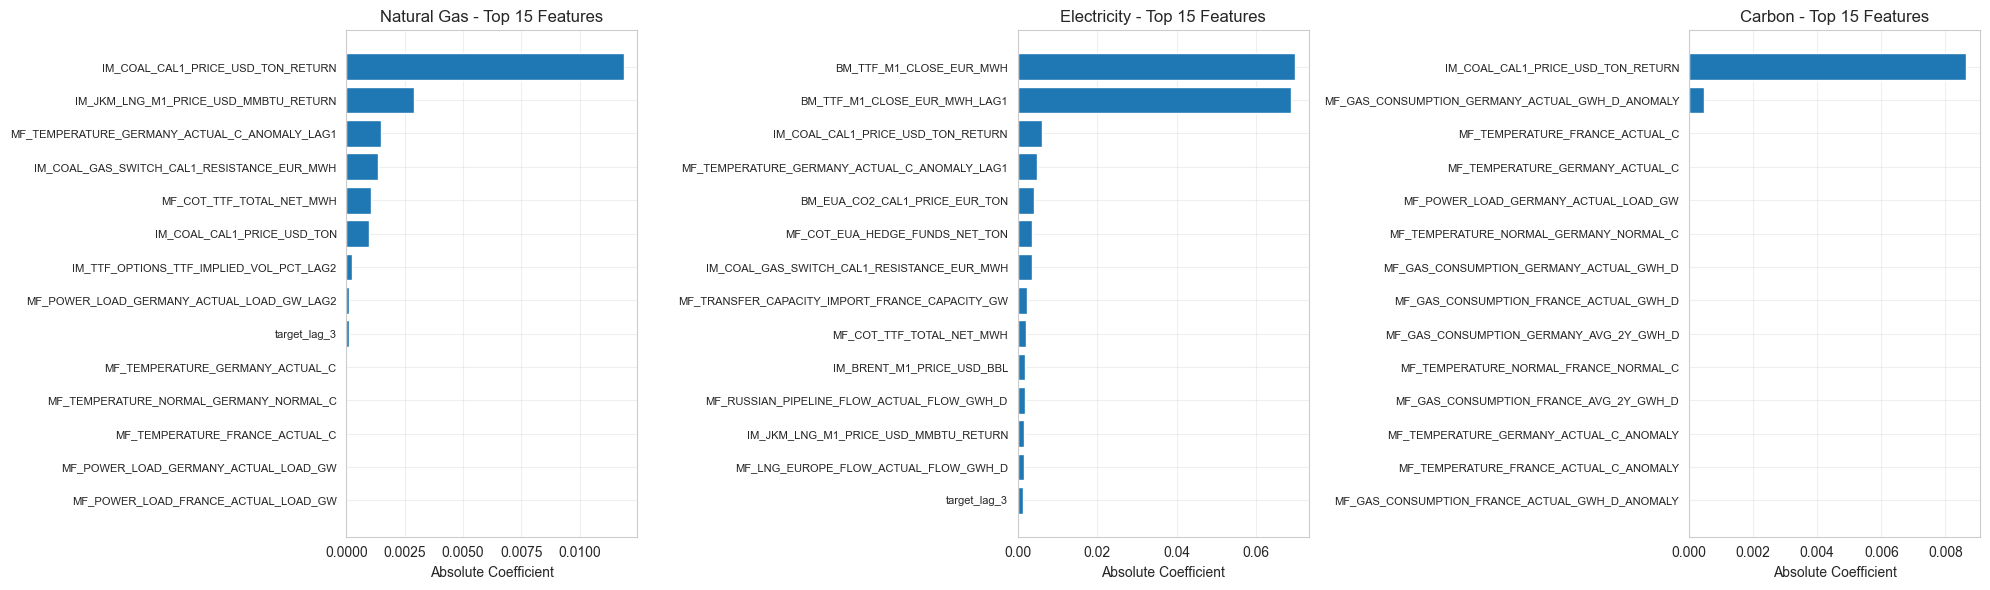

In [13]:
# Visualize coefficient importance
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

models = [model_gas, model_power, model_carbon]
titles = ['Natural Gas', 'Electricity', 'Carbon']

for idx, (model, title) in enumerate(zip(models, titles)):
    top_features = model.get_top_features(15).iloc[1:]  # Exclude intercept
    
    axes[idx].barh(range(len(top_features)), top_features['abs_coefficient'].values)
    axes[idx].set_yticks(range(len(top_features)))
    axes[idx].set_yticklabels(top_features['feature'].values, fontsize=8)
    axes[idx].set_xlabel('Absolute Coefficient')
    axes[idx].set_title(f'{title} - Top 15 Features')
    axes[idx].invert_yaxis()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 7: Compare Performance Across Markets

Compare validation metrics across all three markets.

PERFORMANCE COMPARISON ACROSS MARKETS
     Market  Avg RMSE  Avg MAE    Avg R²  N Folds
Natural Gas  0.043728 0.033566  0.107043       36
Electricity  0.037593 0.027222  0.216950       36
     Carbon  0.024245 0.019082 -0.008027       36


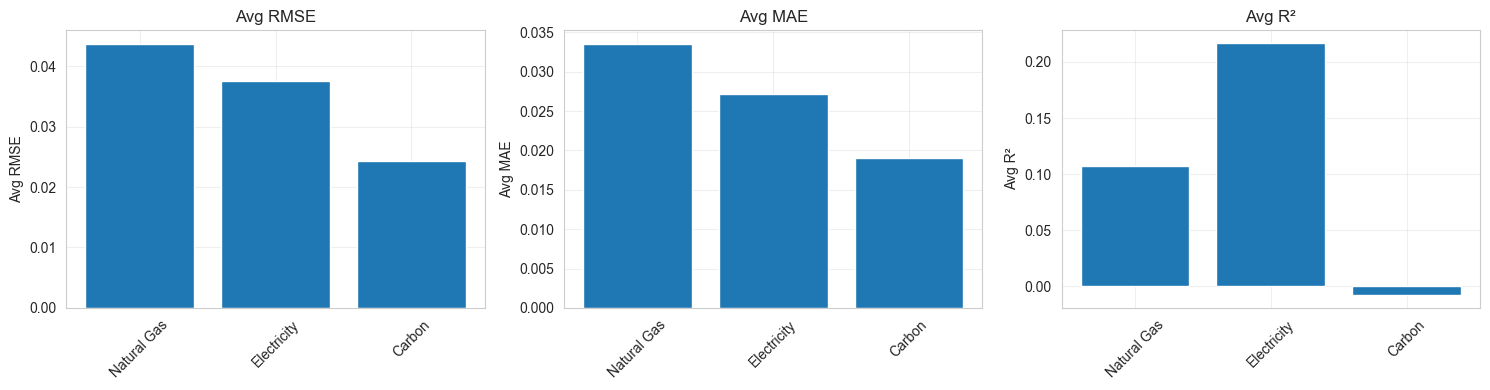

In [14]:
# Compare average metrics across markets
comparison = pd.DataFrame({
    'Market': ['Natural Gas', 'Electricity', 'Carbon'],
    'Avg RMSE': [
        results_gas['rmse'].mean(),
        results_power['rmse'].mean(),
        results_carbon['rmse'].mean()
    ],
    'Avg MAE': [
        results_gas['mae'].mean(),
        results_power['mae'].mean(),
        results_carbon['mae'].mean()
    ],
    'Avg R²': [
        results_gas['r2'].mean(),
        results_power['r2'].mean(),
        results_carbon['r2'].mean()
    ],
    'N Folds': [
        len(results_gas),
        len(results_power),
        len(results_carbon)
    ]
})

print("="*70)
print("PERFORMANCE COMPARISON ACROSS MARKETS")
print("="*70)
print(comparison.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['Avg RMSE', 'Avg MAE', 'Avg R²']
for idx, metric in enumerate(metrics):
    axes[idx].bar(comparison['Market'], comparison[metric])
    axes[idx].set_title(metric)
    axes[idx].set_ylabel(metric)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 8: Future Extensions - Regime Models

**Framework is regime-ready:**

The current setup can be extended with regime models:

**Hard Regimes (Two Models):**
$$y_t = \alpha_{s_t} + X_t^T \beta_{s_t} + \varepsilon_t$$

Fit separate coefficients per regime, providing interpretable "beta tables" for each market state.

**Soft Regimes (More Stable):**
Weight predictions by regime probabilities for smoother transitions.

**Configuration available in `config.py`:**
- Set `REGIME_PARAMS['enabled'] = True`
- Specify regime features and number of states
- Choose hard vs soft regime approach

## Summary and Key Takeaways

**Framework Highlights:**
1. ✅ **3 Targets Defined:** Natural Gas (TTF), Electricity (Germany), Carbon (EUA)
2. ✅ **Log-Return Transform:** Removes trends, interpretable coefficients
3. ✅ **4 Feature Blocks:** Demand, Supply, Market Positioning, Cross-Commodity
4. ✅ **Target-Specific Features:** Each market gets custom must-have drivers
5. ✅ **Elastic Net with Lags:** Interpretable, regularized, handles dynamics
6. ✅ **Walk-Forward Validation:** Robust out-of-sample testing
7. ✅ **Regime-Ready:** Structure supports future regime modeling

**Next Steps:**
- Fine-tune hyperparameters (alpha, l1_ratio, lag selection)
- Add more sophisticated anomaly detection
- Implement regime detection and switching models
- Expand to multi-step ahead forecasts
- Add trading strategy backtests based on forecasts